In [1]:
from prismo import PRISMO
import matplotlib.pyplot as plt
import numpy as np
from plotnine import *
import pandas as pd

Importing the dtw module. When using in academic works please cite:
  T. Giorgino. Computing and Visualizing Dynamic Time Warping Alignments in R: The dtw Package.
  J. Stat. Soft., doi:10.18637/jss.v031.i07.



In [2]:
models = []

for i in range(10):
    models.append(PRISMO.load(f"models/model_{i}.h5"))

In [3]:
df_list = []

for i, model in enumerate(models):
    df = pd.DataFrame({
        "factor_name": model.factor_names,
        "n_annotations" : model._annotations["rna"].sum(axis=1),
        "n_features": model.n_features["rna"],
        "model": str(i),
    })
    df = df[~df.factor_name.str.startswith("Factor")]
    df["annotations_fraction"] = df["n_annotations"] / df["n_features"]
    df.set_index("factor_name", inplace=True)
    df.index.name = "pathway"
    df["r2_chromium"] = models[i].get_r2()["group_chromium"]["rna"]
    df["r2_xenium"] = models[i].get_r2()["group_xenium"]["rna"]
    df["rank_chromium"] = df["r2_chromium"].rank(method="first", ascending=False).astype(int) - 1
    df["rank_chromium_normalized"] = df["rank_chromium"] / len(df)
    df["rank_xenium"] = df["r2_xenium"].rank(method="first", ascending=False).astype(int) - 1
    df["rank_xenium_normalized"] = df["rank_xenium"] / len(df)
    df_list.append(df)

df = pd.concat(df_list)

df = df.groupby("pathway").agg(
    mean_rank_chromium=('rank_chromium_normalized', 'mean'),
    std_rank_chromium=('rank_chromium_normalized', 'std'),
    mean_rank_xenium=('rank_xenium_normalized', 'mean'),
    std_rank_xenium=('rank_xenium_normalized', 'std'),
    mean_annotations_fraction=('annotations_fraction', 'mean'),
    std_annotations_fraction=('annotations_fraction', 'std'),
).reset_index()

df["pathway"] = df["pathway"].str.replace("HALLMARK_", "").str.replace("_", " ").str.title()

/data/florin/micromamba/envs/prismo/lib/python3.11/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_errorbar : Removed 4 rows containing missing values.
/data/florin/micromamba/envs/prismo/lib/python3.11/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_errorbarh : Removed 6 rows containing missing values.


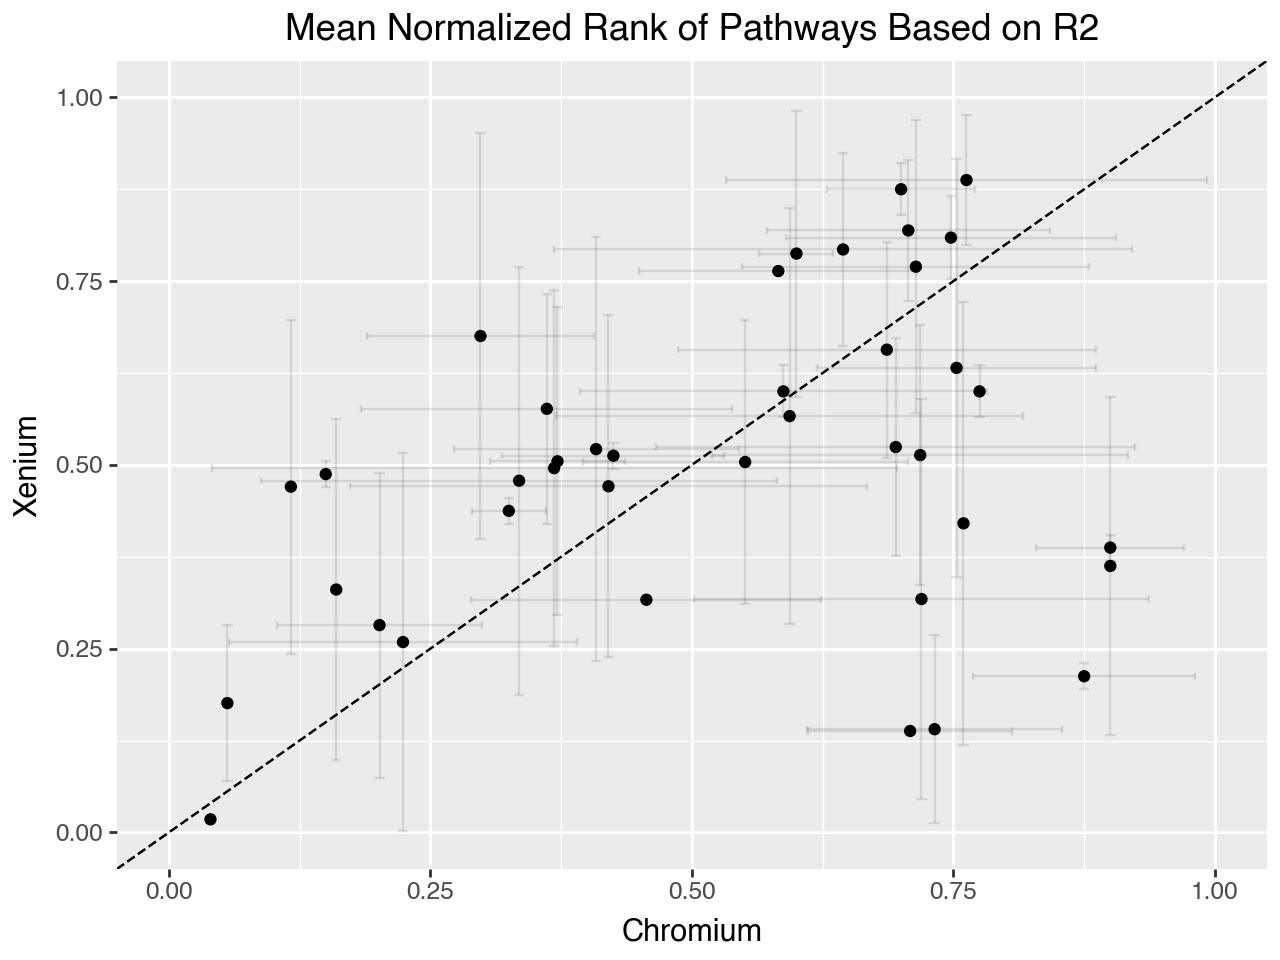

In [4]:
plot = (
    ggplot(df, aes(x="mean_rank_chromium", y="mean_rank_xenium"))
    + geom_point()
    + geom_abline(intercept=0, slope=1, linetype="dashed")
    + geom_errorbar(aes(ymin="mean_rank_xenium-std_rank_xenium", ymax="mean_rank_xenium+std_rank_xenium"), alpha=0.1, width=0.01)
    + geom_errorbarh(aes(xmin="mean_rank_chromium-std_rank_chromium", xmax="mean_rank_chromium+std_rank_chromium"), alpha=0.1, height=0.01)
    + xlim(0, 1)
    + ylim(0, 1)
    + labs(x="Chromium", y="Xenium", title="Mean Normalized Rank of Pathways Based on R2")
)
plot.show()

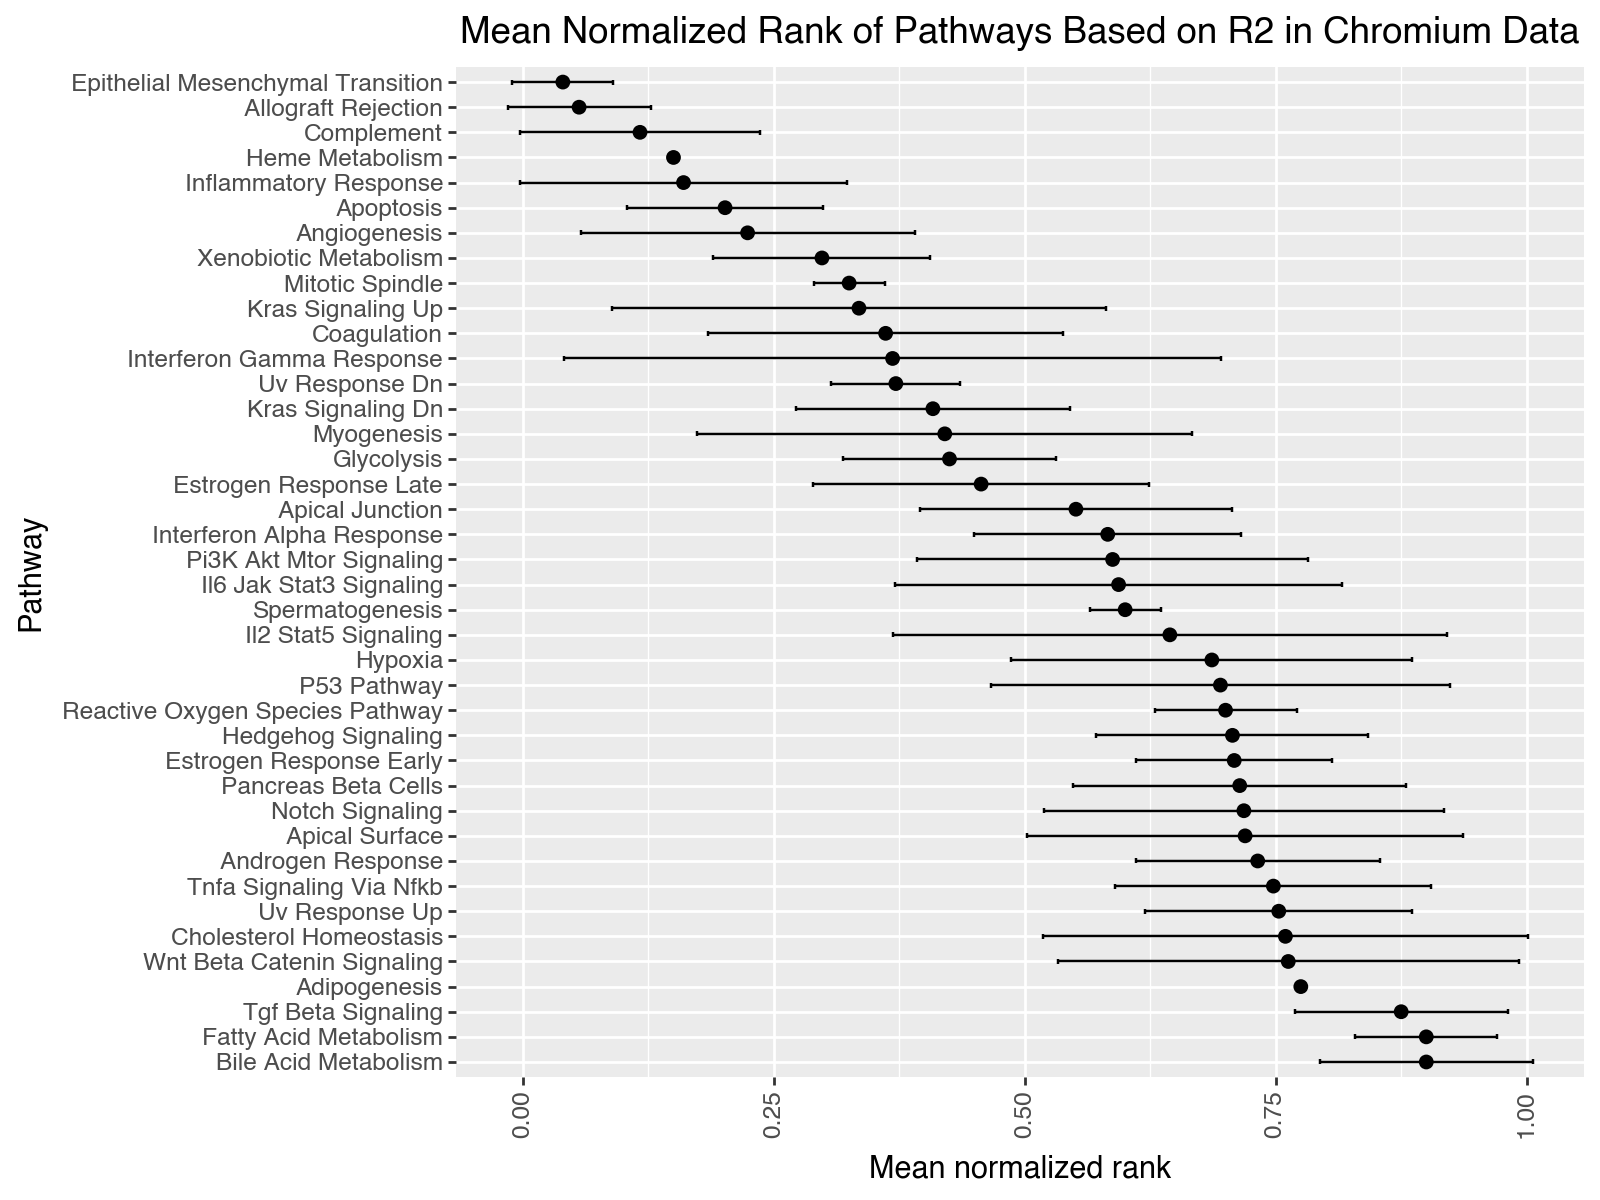

In [5]:
df_copy = df.copy()
df_copy["pathway"] = pd.Categorical(df["pathway"], categories=df.set_index("pathway")["mean_rank_chromium"].sort_values(ascending=False).index, ordered=True)

plot = (
    ggplot(df_copy, aes(y="pathway", x="mean_rank_chromium"))
    + geom_point(size=2)
    + geom_errorbarh(aes(xmin="mean_rank_chromium-std_rank_chromium", xmax="mean_rank_chromium+std_rank_chromium"), height=0.2)
    + theme(axis_text_x=element_text(rotation=90), figure_size=(8, 6))
    + labs(y="Pathway", x="Mean normalized rank", title="Mean Normalized Rank of Pathways Based on R2 in Chromium Data")
)
plot.show()

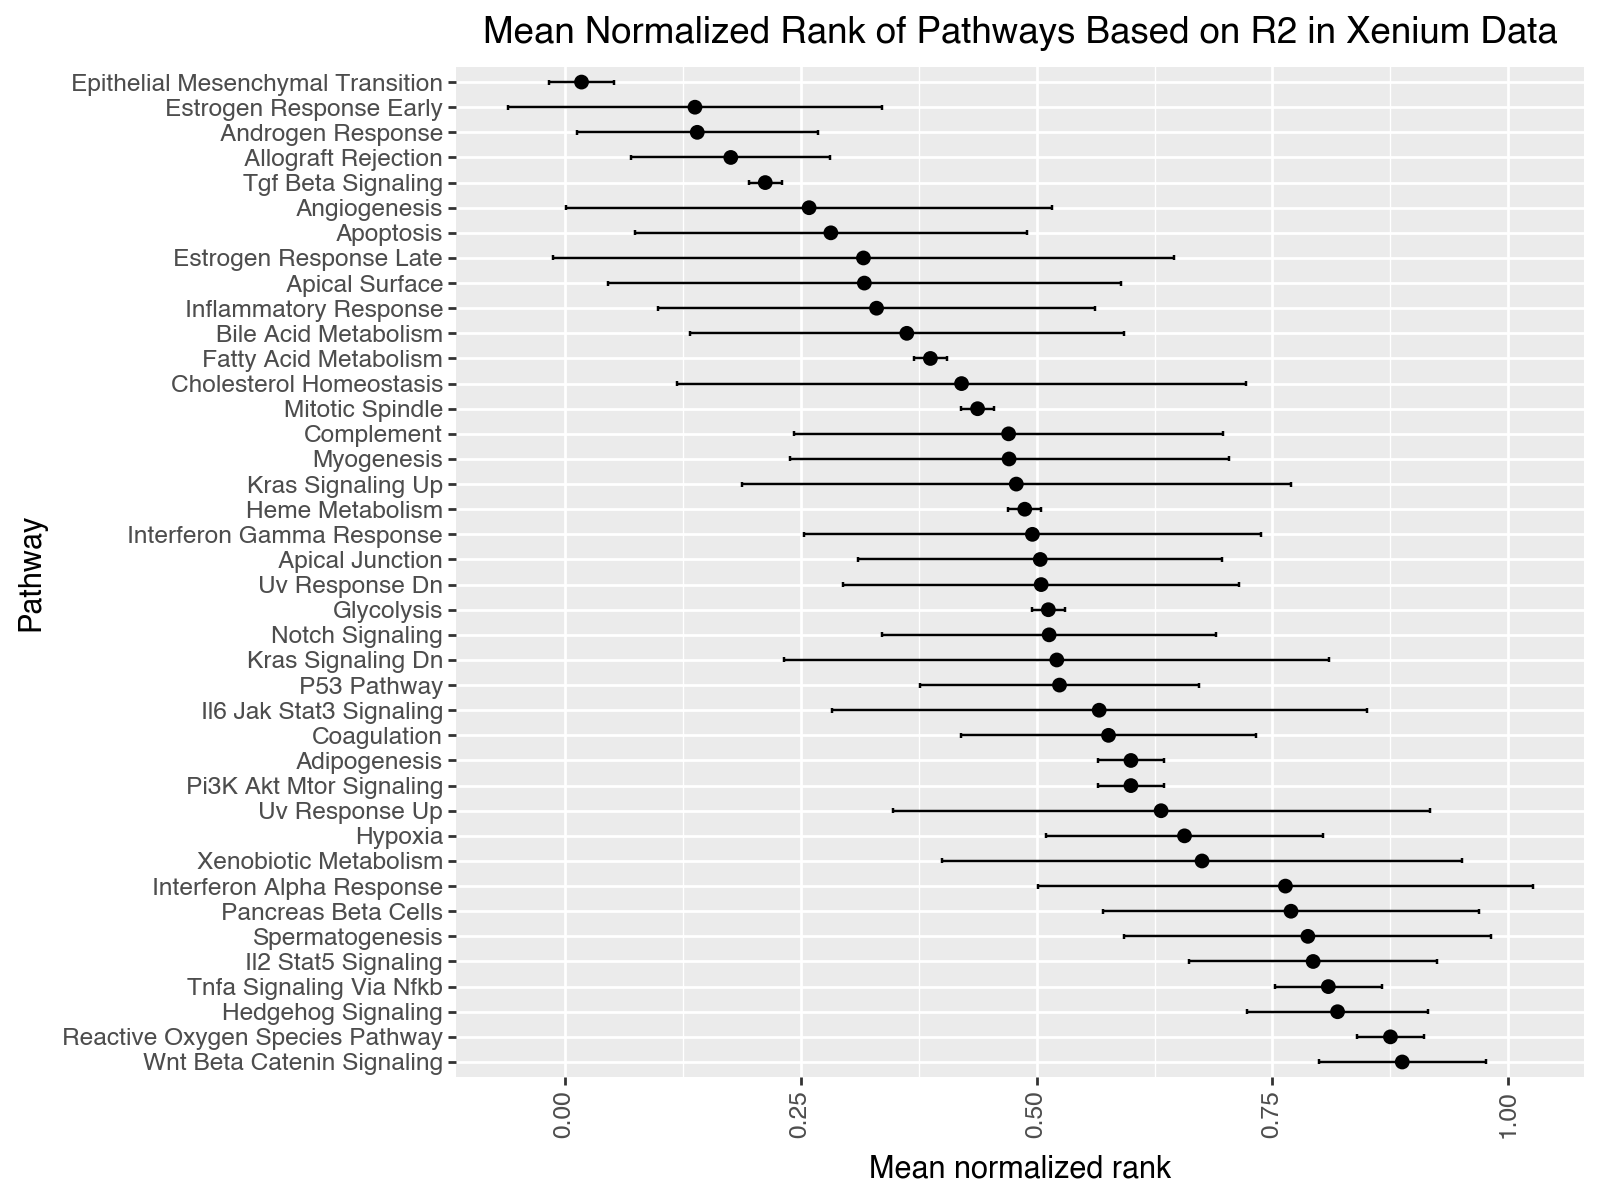

In [6]:
df_copy= df.copy()
df_copy["pathway"] = pd.Categorical(df["pathway"], categories=df.set_index("pathway")["mean_rank_xenium"].sort_values(ascending=False).index, ordered=True)

plot = (
    ggplot(df_copy, aes(y="pathway", x="mean_rank_xenium"))
    + geom_point(size=2)
    + geom_errorbarh(aes(xmin="mean_rank_xenium-std_rank_xenium", xmax="mean_rank_xenium+std_rank_xenium"), height=0.2)
    + theme(axis_text_x=element_text(rotation=90), figure_size=(8, 6))
    + labs(y="Pathway", x="Mean normalized rank", title="Mean Normalized Rank of Pathways Based on R2 in Xenium Data")
)
plot.show()

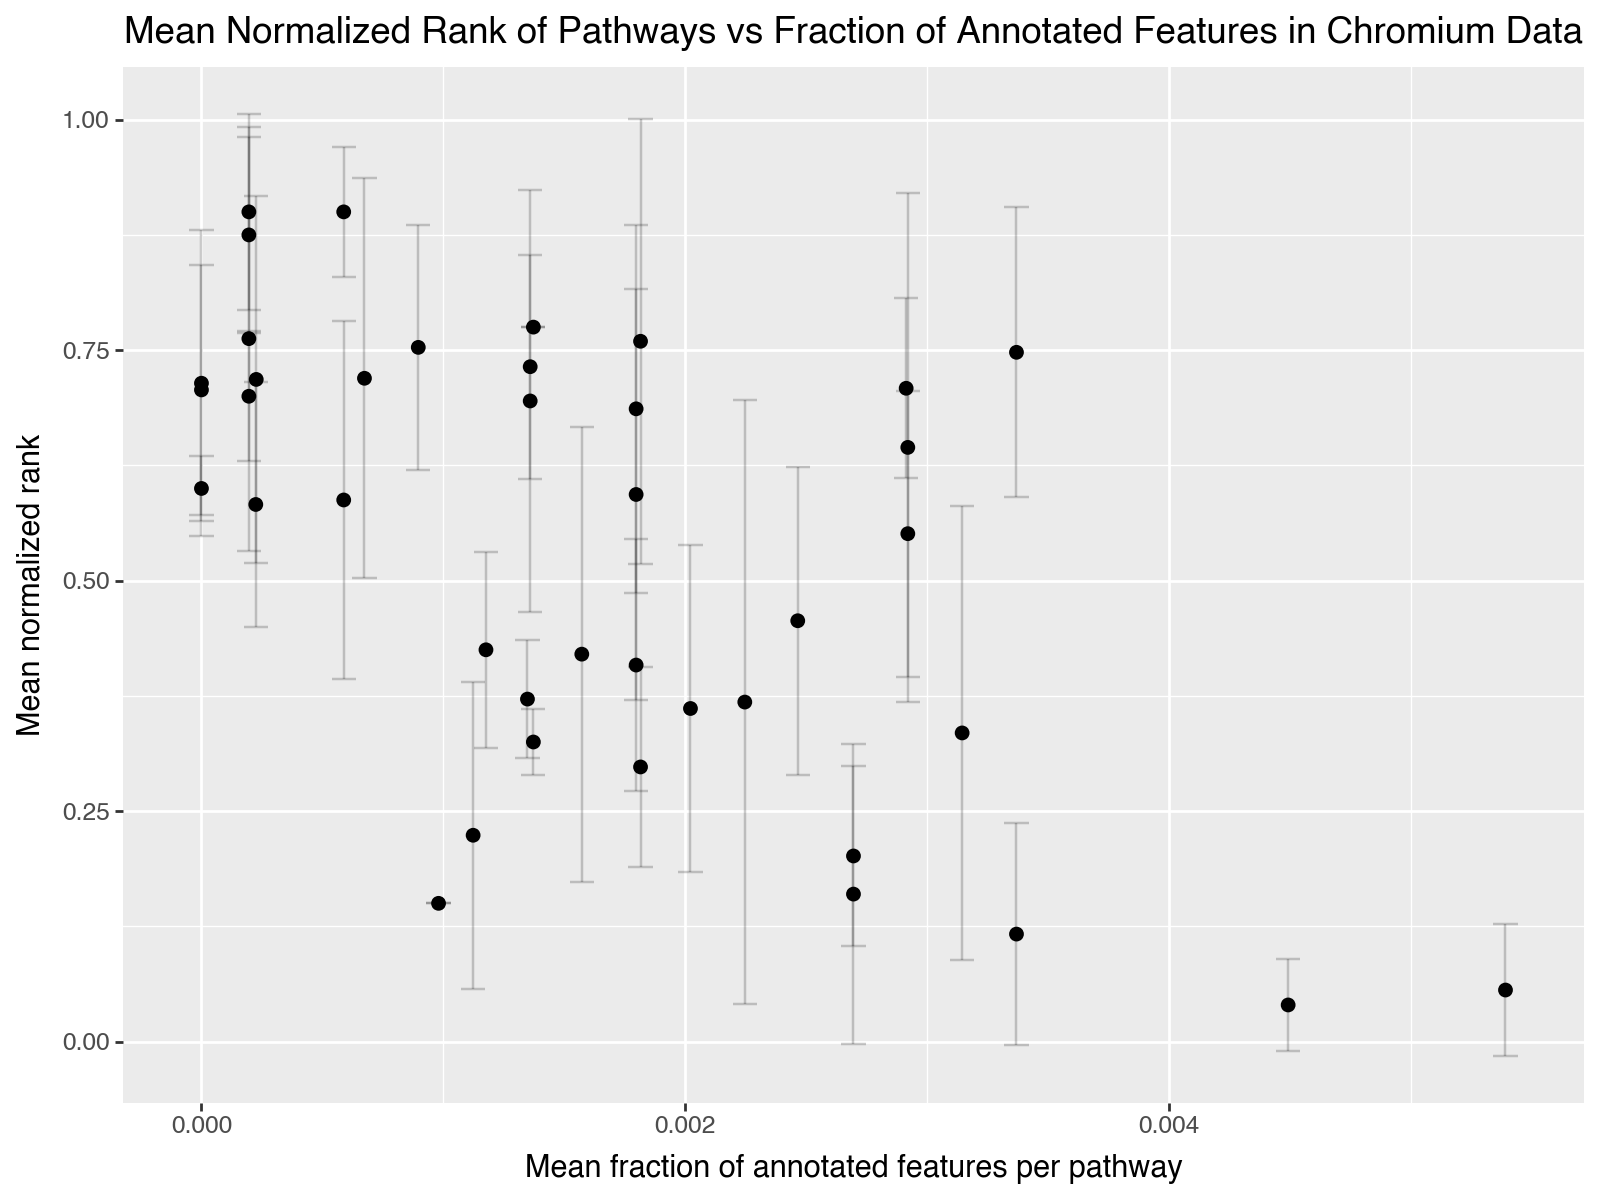

In [7]:
plot = (
    ggplot(df, aes(x="mean_annotations_fraction", y="mean_rank_chromium"))
    + geom_point(size=2)
    + geom_errorbar(aes(ymin="mean_rank_chromium-std_rank_chromium", ymax="mean_rank_chromium+std_rank_chromium"), width=0.0001, alpha=0.2)
    + theme(figure_size=(8, 6))
    + labs(x="Mean fraction of annotated features per pathway", y="Mean normalized rank", title="Mean Normalized Rank of Pathways vs Fraction of Annotated Features in Chromium Data")
)
plot.show()

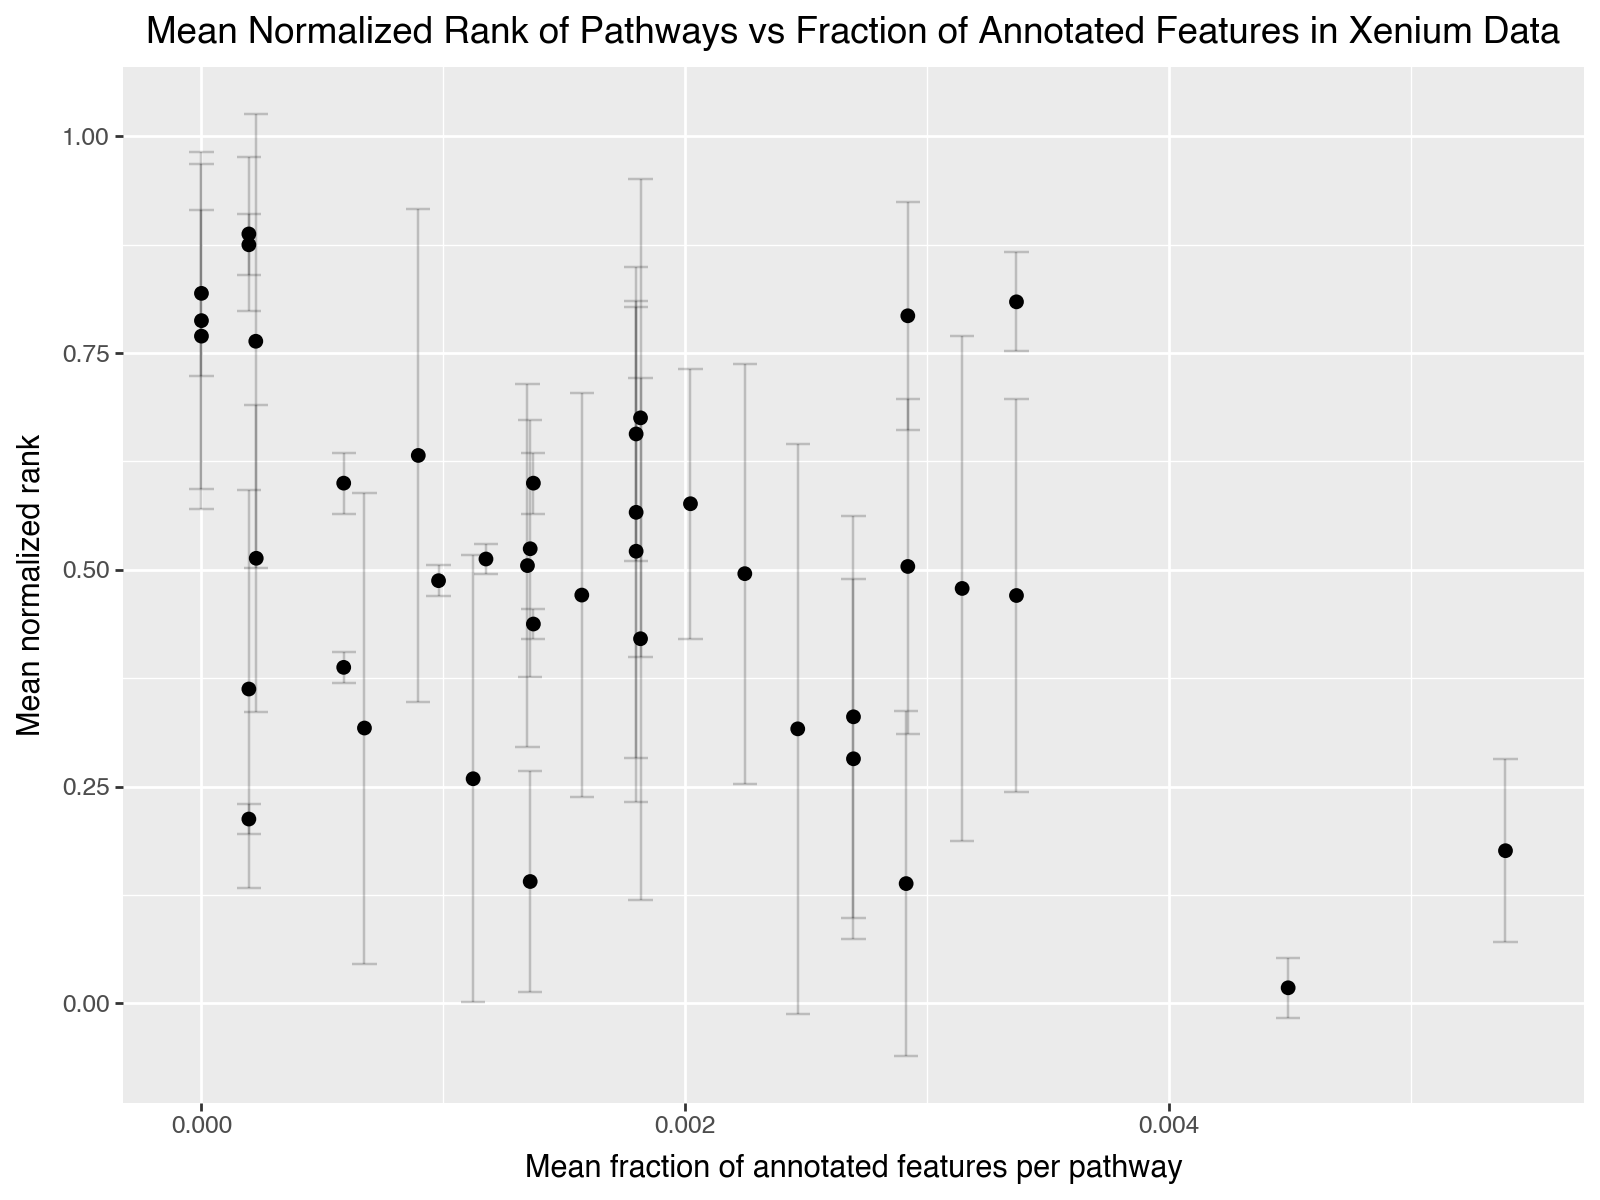

In [8]:
plot = (
    ggplot(df, aes(x="mean_annotations_fraction", y="mean_rank_xenium"))
    + geom_point(size=2)
    + geom_errorbar(aes(ymin="mean_rank_xenium-std_rank_xenium", ymax="mean_rank_xenium+std_rank_xenium"), width=0.0001, alpha=0.2)
    + theme(figure_size=(8, 6))
    + labs(x="Mean fraction of annotated features per pathway", y="Mean normalized rank", title="Mean Normalized Rank of Pathways vs Fraction of Annotated Features in Xenium Data")
)
plot.show()